In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D

from sklearn.metrics import fbeta_score
from sklearn.model_selection import train_test_split

import cv2
import os
from tqdm import tqdm


from os import listdir
import csv

In [2]:
# load csv
df_train = pd.read_csv('../input/planets-dataset/planet/planet/train_classes.csv')
df_train.sample(5)

,image_name,tags
7411,train_7411,cloudy
16301,train_16301,haze primary
4301,train_4301,clear primary
16699,train_16699,clear primary
16590,train_16590,clear primary


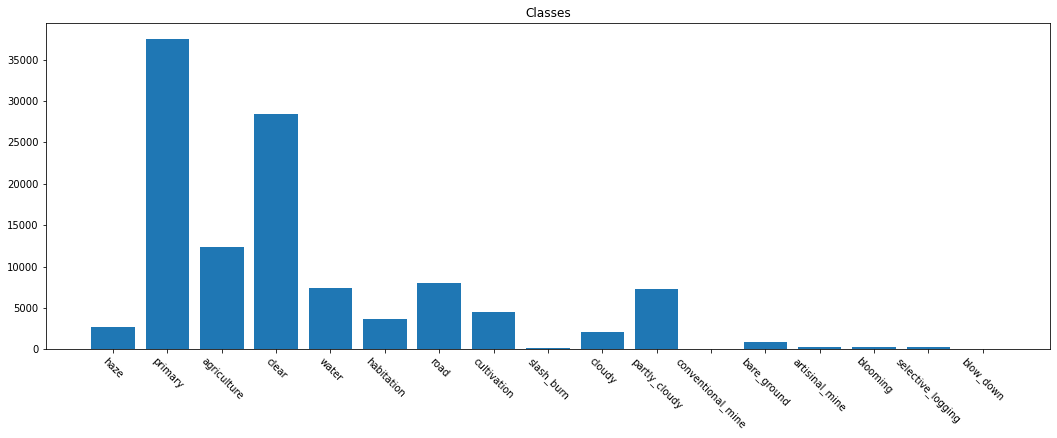

In [3]:
# numbers of tags and their names
counts = {}
splitted_tags = df_train['tags'].map(lambda x: x.split(' '))
for labels in splitted_tags.values:
    for label in labels:
        counts[label] = counts[label] + 1  if label in counts else 0

plt.figure(figsize=(18, 6))
plt.title('Classes')
idxs = range(len(counts.values()))
plt.xticks(idxs, counts.keys(), rotation=-45)
plt.bar(idxs, counts.values());

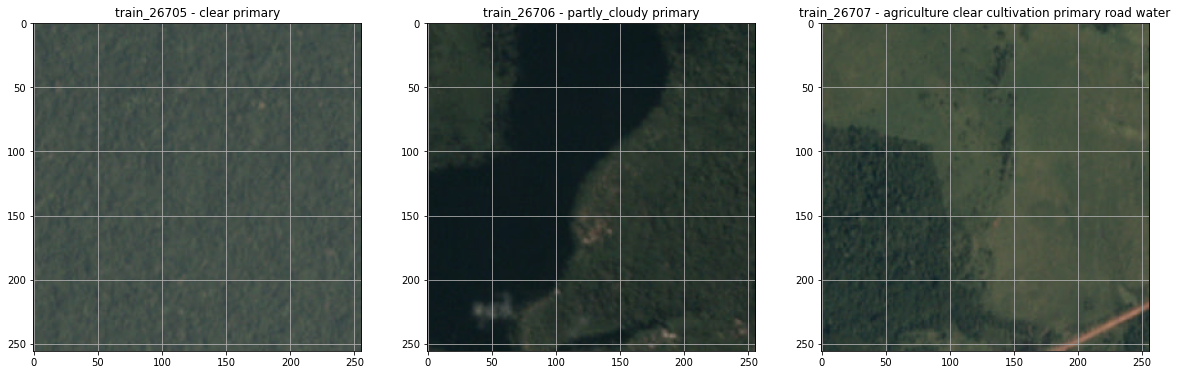

In [4]:
# random images
plt.rc('axes', grid = True)

_, ax = plt.subplots(1, 3, figsize=(20, 20))
random_img = np.random.randint(0,len(df_train) - 3)
for i , (file, label) in enumerate(df_train[random_img:random_img + 3].values):
    img = cv2.imread('../input/planets-dataset/planet/planet/train-jpg/{}.jpg'.format(file))
    ax[i].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    ax[i].set_title('{} - {}'.format(file, label))
    
plt.show()

In [5]:
# Preprocess labels
x_train = []
x_test = []
y_train = []


flatten = lambda l: [item for sublist in l for item in sublist]
labels = list(set(flatten([l.split(' ') for l in df_train['tags'].values])))

label_map = {l: i for i, l in enumerate(labels)}
inv_label_map = {i: l for l, i in label_map.items()}

In [6]:
# Prepare array of images and vector representation of labels
for f, tags in tqdm(df_train.values, miniters=1000):
    img = cv2.imread('../input/planets-dataset/planet/planet/train-jpg/{}.jpg'.format(f))
    targets = np.zeros(17)
    for t in tags.split(' '):
        targets[label_map[t]] = 1 
    x_train.append(cv2.resize(img, (32, 32)))
    y_train.append(targets)

100%|██████████| 40479/40479 [04:56<00:00, 136.46it/s]


In [7]:
# Maximum and minimum values in the array of training images
max_value = np.amax(x_train)
min_value = np.amin(x_train)

print('Min value in the training images array: ', min_value)
print('Max value in the training images array: ', max_value)

Min value in the training images array:  1
Max value in the training images array:  255


In [8]:
# Normalize images into the interval [0,1]
y_train = np.array(y_train, np.uint8)
x_train = np.array(x_train, np.float16) / 255.
print("Shape of the training images array is: ")
print(x_train.shape)
print("Shape of the training labels array is: ")
print(y_train.shape)

Shape of the training images array is: 
(40479, 32, 32, 3)
Shape of the training labels array is: 
(40479, 17)


In [9]:
# Split between training and validation sets
split = 35000 # Approx. 86% for training and 14% for validation
x_train, x_valid, y_train, y_valid = (x_train[:split], x_train[split:], 
                                      y_train[:split], y_train[split:])

In [10]:
# Create structure of Convolutional Neural Network
model = Sequential()

model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=(32, 32, 3)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(17, activation='sigmoid'))

model.compile(loss='binary_crossentropy', 
              # We NEED binary here, since categorical_crossentropy 
              # l1 norms the output before calculating loss.
              optimizer='adam',
              metrics=['accuracy'])

2022-09-20 21:18:41.478744: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [11]:
# Train model              
history = model.fit(x_train, y_train,
          batch_size=128,
          epochs=12,
          verbose=1,
          validation_data=(x_valid, y_valid))

2022-09-20 21:18:42.186955: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/12
274/274 [==============================] - 43s 155ms/step - loss: 0.2554 - accuracy: 0.0711 - val_loss: 0.2029 - val_accuracy: 0.0633
Epoch 2/12
274/274 [==============================] - 43s 155ms/step - loss: 0.2060 - accuracy: 0.0696 - val_loss: 0.1886 - val_accuracy: 0.0584
Epoch 3/12
274/274 [==============================] - 43s 157ms/step - loss: 0.1945 - accuracy: 0.0747 - val_loss: 0.1788 - val_accuracy: 0.0692
Epoch 4/12
274/274 [==============================] - 43s 158ms/step - loss: 0.1874 - accuracy: 0.0828 - val_loss: 0.1728 - val_accuracy: 0.0767
Epoch 5/12
274/274 [==============================] - 44s 159ms/step - loss: 0.1810 - accuracy: 0.0901 - val_loss: 0.1659 - val_accuracy: 0.0752
Epoch 6/12
274/274 [==============================] - 43s 155ms/step - loss: 0.1782 - accuracy: 0.0990 - val_loss: 0.1683 - val_accuracy: 0.0936
Epoch 7/12
274/274 [==============================] - 43s 156ms/step - loss: 0.1755 - accuracy: 0.0992 - val_loss: 0.1621 - val_ac

In [12]:
# Use the model to predict
p_valid = model.predict(x_valid, batch_size=128)

#np.set_printoptions(precision=2)
np.set_printoptions(formatter={'float': '{: 0.3f}'.format})

print("## For a sample of 3 images and the first 5 labels (of 17)\n")
print("True vectorized labels")
print(np.round(y_valid[0:3,0:7]/1.0,2))
print("-------------------------------------------------------")
print("Predicted vectorized labels")
print(np.round(p_valid[0:3,0:7],2))

## For a sample of 3 images and the first 5 labels (of 17)

True vectorized labels
[[ 0.000  0.000  0.000  0.000  1.000  0.000  1.000]
 [ 0.000  1.000  0.000  1.000  0.000  0.000  0.000]
 [ 0.000  0.000  0.000  1.000  1.000  0.000  0.000]]
-------------------------------------------------------
Predicted vectorized labels
[[ 0.100  0.270  0.020  0.880  0.250  0.010  0.010]
 [ 0.210  0.410  0.040  0.900  0.270  0.000  0.010]
 [ 0.310  0.450  0.030  0.840  0.270  0.000  0.010]]


In [13]:
print(fbeta_score(y_valid, np.array(p_valid) > 0.2, beta=2, average='samples'))

0.8586723915936123


In [14]:
path_test_file_1 = "../input/planets-dataset/planet/planet/test-jpg"
path_test_file_2 = "../input/planets-dataset/test-jpg-additional/test-jpg-additional"


# kaggle submission
X_test = []
submission = []
for file in listdir('../input/planets-dataset/planet/planet/test-jpg'):
    filename = file.split('.')[0]
    
    img = cv2.imread('../input/planets-dataset/planet/planet/test-jpg/{}.jpg'.format(filename))
    targets = np.zeros(17)
    
    X_test.append(cv2.resize(img, (32, 32)))
    submission.append(filename)

for file in listdir('../input/planets-dataset/test-jpg-additional/test-jpg-additional'):
    filename = file.split('.')[0]
    
    img = cv2.imread('../input/planets-dataset/test-jpg-additional/test-jpg-additional/{}.jpg'.format(filename))
    targets = np.zeros(17)
    
    X_test.append(cv2.resize(img, (32, 32)))
    submission.append(filename)

X_test = np.array(X_test, np.float16) / 255

# con = np.concatenate((arr, arr1), axis=1)

y_test = model.predict(X_test, batch_size=128)

with open('submission.csv', 'w', newline='') as csvfile:
    csv_writer = csv.writer(csvfile, delimiter=',',
                            quotechar='|', quoting=csv.QUOTE_MINIMAL)
    csv_writer.writerow(('image_name', 'tags'))
    for i, image in enumerate(submission):
        csv_writer.writerow((image, ' '.join(np.array(labels)[y_test[i] > 0.2])))